# Modeling

## Import data

In [14]:
import pandas as pd

# Read dataframe from the pickle format
wide_df = pd.read_pickle("../../data/processed/preprocessed_df.pkl")

## Select features

'sex_gender': 0 represents female and 1 represents male

'age': Age in years

'eeg': number of EEGs per patient

'engel_outcomes': number of Engel outcomes per patient

'mri': number of MRIs per patient

'neuroanatomical_labeling': number of Neuroanatomical labeling per patient

...

In [15]:
X = wide_df[["sex_gender", "age", "eeg", "engel_outcomes", "mri", "phys_findings", "age_of_onset", "eo_yrs_postsurg",
             "neuroanatomical_labeling", "neuropsychological_testing", "surg_stage", "neuro_findings", "eo_year_surg",
             "surgical_information", "resect_procedure___1", "resect_procedure___2", "resect_procedure___3",
             "resect_procedure___4", "resect_procedure___5", "resect_procedure___6", "resect_procedure___7",
             "resect_procedure___8", "resect_procedure___9", "resect_procedure___10", "resect_procedure___11",
             "resect_procedure___12", "resect_procedure___14", "resect_procedure___15"]]

y = wide_df["surg_engel"]

# Turns the outcome variable from range [1,4] to [0,3]
y = y - 1

## Correlation matrix

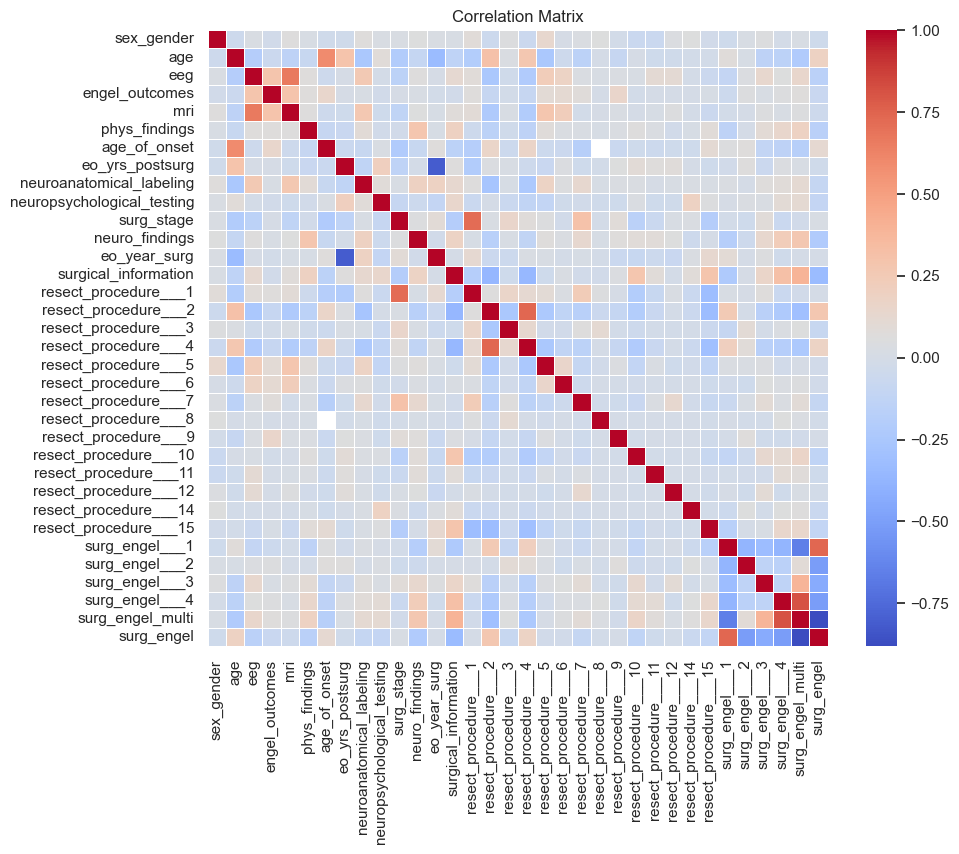

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

engel = wide_df[['surg_engel___1', 'surg_engel___2', 'surg_engel___3', 'surg_engel___4', 'surg_engel']]
engel = engel.rename(columns={'surg_engel': 'surg_engel_multi'})
engel = pd.concat([engel, y], axis=1)

# Calculate the correlation matrix
correlation_matrix = pd.concat([X, engel], axis=1).corr()

# Create a heatmap using seaborn
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

## To transform from a multiclass prediction to a single class prediction

In [17]:
# Trying to predict Engel class I
y = y==0

## Split data into train/test

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## 10-fold cross-validation

This step is done here in order to avoid data leakage of the scaling and imputing into the validation set used in the CV

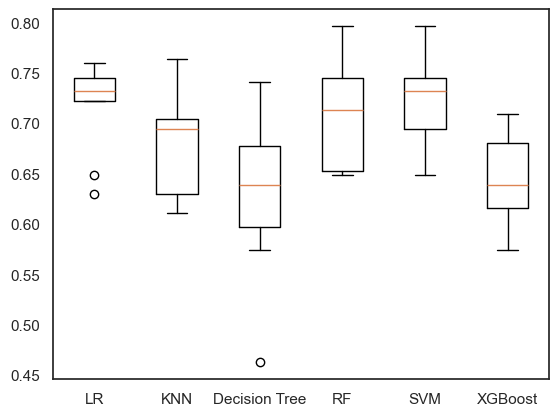

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

# List of continuous and non-continuous variables
numeric_var = ["age", "age_of_onset", "eo_yrs_postsurg", "eo_year_surg",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information"]
column_names = numeric_var + list(set(X_train.columns) - set(numeric_var))

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define models
models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

results = []

# Loop through models
for model_name, model in models.items():
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Create a stratified k-fold cross-validator
    kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    # Cross-validate using the pipeline
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kf)

    # Append cross-validation results to the results list
    results.append(cv_results)

# Plot the results
plt.boxplot(results, labels=models.keys())
plt.show()

## Scale continuous variables

In [20]:
# Fit and transform on training and testing data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

## Null accuracy

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a DummyClassifier that always predicts the most frequent class
dummy_classifier = DummyClassifier(strategy='most_frequent')

# Fit the DummyClassifier on the training data
dummy_classifier.fit(X_train, y_train)

# Make predictions on the training data
y_pred_dummy = dummy_classifier.predict(X_train)

# Calculate null accuracy
null_accuracy = accuracy_score(y_train, y_pred_dummy)

print(f"Null Accuracy: {null_accuracy:.2f}")


Null Accuracy: 0.63


## ROC AND AUC

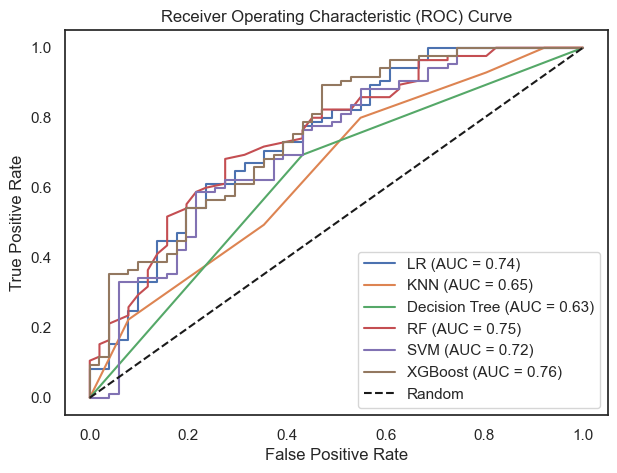

In [22]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

plt.figure(figsize=(7, 5))

for name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train_scaled, y_train)

    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For models without predict_proba, use decision function
        y_pred_prob = model.decision_function(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a Logistic Regression classifier
lr = LogisticRegression(max_iter=2000, random_state=42)

# Train the classifier on the training data
lr.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.69


### Logistic Regression Coefficients

\begin{equation}
P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + \beta_2x_2 + \ldots + \beta_nx_n)}}
\end{equation}

* Positive Coefficient: A positive coefficient for a feature means that an increase in that feature's value is associated with an increase in the log-odds of the response variable being in the positive class.

* Negative Coefficient: A negative coefficient for a feature means that an increase in that feature's value is associated with a decrease in the log-odds of the response variable being in the positive class.

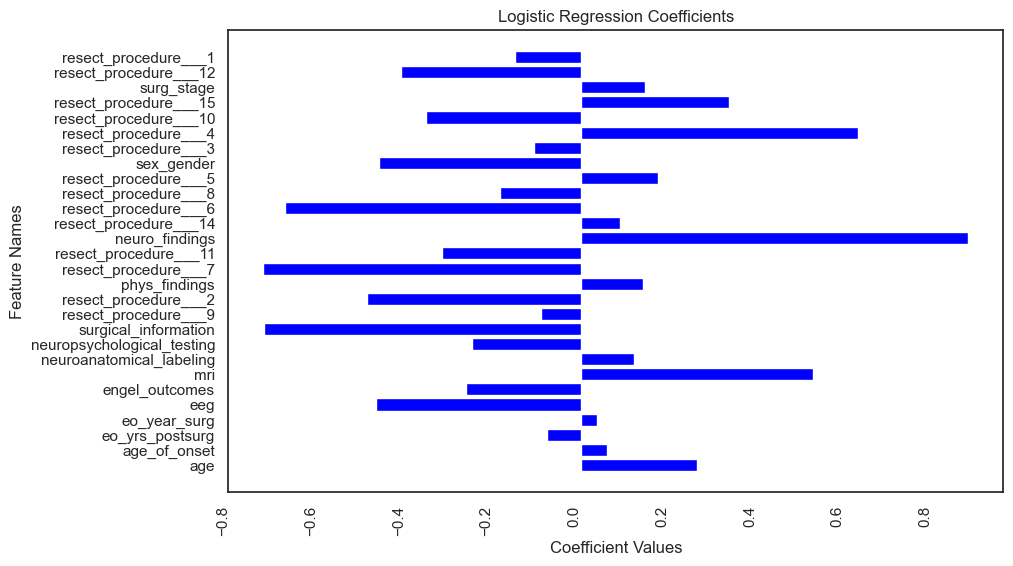

In [28]:
import numpy as np

# Get the coefficients and feature names
coefficients = lr.coef_.flatten()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(column_names, coefficients, color='blue')
plt.xlabel('Coefficient Values')
plt.ylabel('Feature Names')
plt.title('Logistic Regression Coefficients')
plt.xticks(rotation=90, ha="right")
plt.show()

In [29]:
# Get the intercept and coefficients
intercept = lr.intercept_[0]
coefficients = lr.coef_[0]

# Display the logistic regression equation
equation = f"P(Y=1) = 1 / (1 + e^(-({intercept:.4f} + "
for feature, coefficient in zip(numeric_var, coefficients):
    equation += f"{coefficient:.4f} * {feature} + "
equation = equation[:-2]  # Remove the trailing ' + '
equation += ")))"

print("Logistic Regression Equation:")
print(equation)


Logistic Regression Equation:
P(Y=1) = 1 / (1 + e^(-(2.1924 + 0.2634 * age + 0.0576 * age_of_onset + -0.0781 * eo_yrs_postsurg + 0.0348 * eo_year_surg + -0.4686 * eeg + -0.2615 * engel_outcomes + 0.5273 * mri + 0.1191 * neuroanatomical_labeling + -0.2490 * neuropsychological_testing + -0.7236 * surgical_information )))


### Feature selection

Shows important features by applying LASSO regression (L1 regularization) to penalize the absolute size of coefficients. This tends to shrink some coefficients to zero, effectively selecting a subset of features.

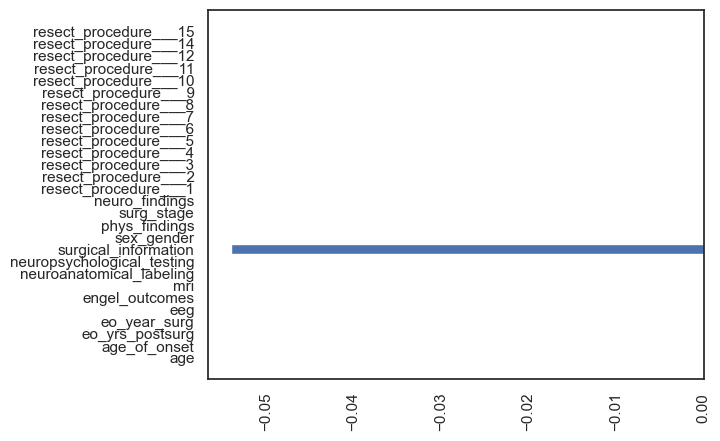

In [38]:
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X_train_scaled, y_train).coef_

# Filter out columns with coefficient equal to 0
nonzero_coef_indices = np.where(lasso_coef != 0)[0]
nonzero_names = [column_names[i] for i in nonzero_coef_indices]  # Use a list comprehension to get the names
nonzero_coef = lasso_coef[nonzero_coef_indices]

plt.barh(column_names, lasso_coef)
plt.xticks(rotation=90)
plt.show()

## Decision Tree classifier

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth = 3, random_state=42)

# Turn outcome variable into dummy variables
y_train_encoded = pd.get_dummies(y_train, columns=["surg_engel"], drop_first=True)
y_test_encoded = pd.get_dummies(y_test, columns=["surg_engel"], drop_first=True)

# Train the classifier on the training data
clf.fit(X_train, y_train_encoded)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.73


### Plot decision tree

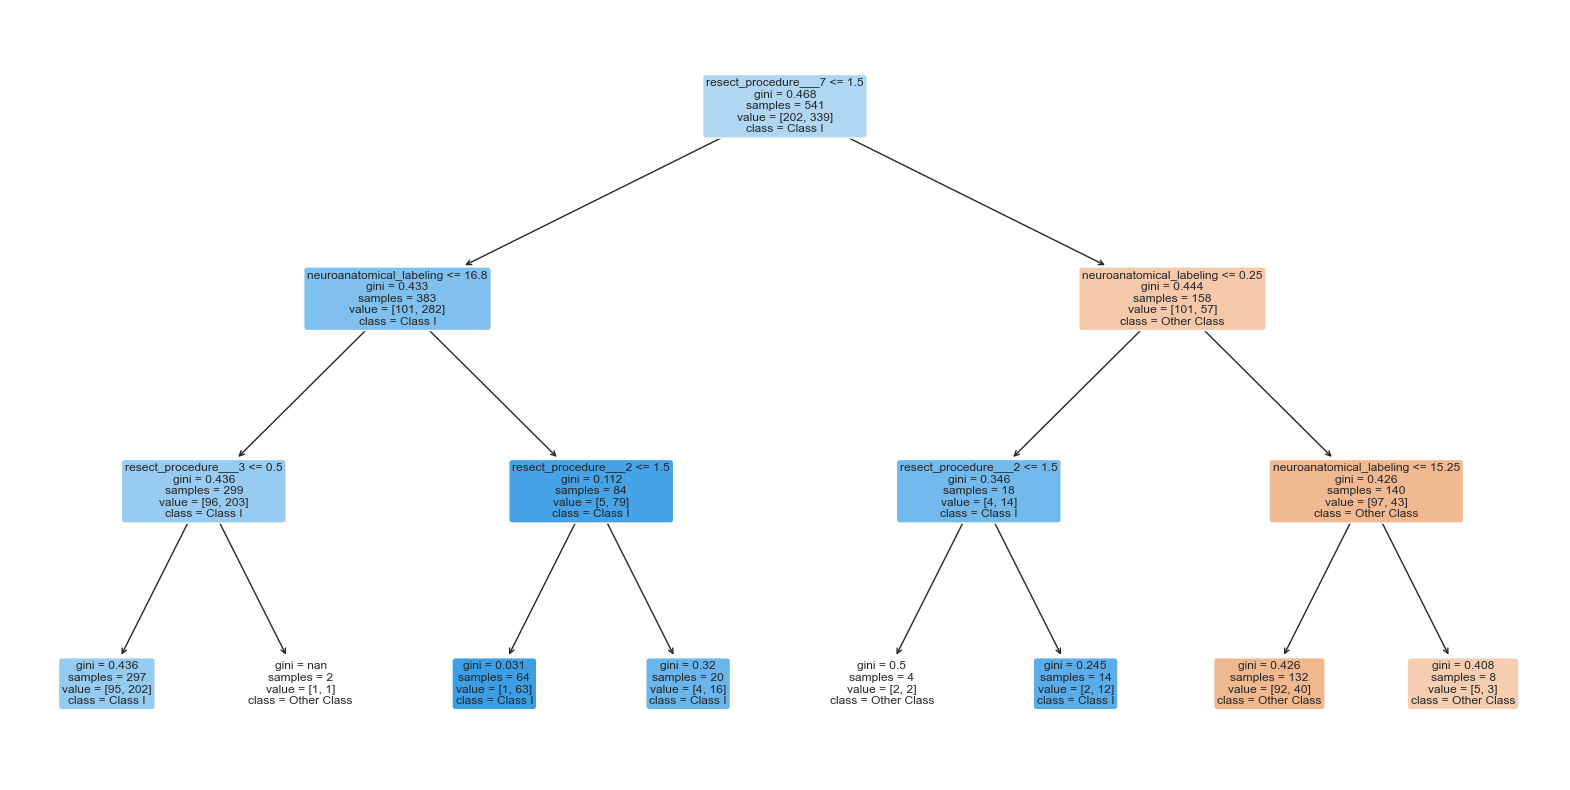

In [31]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=column_names, class_names=["Other Class", "Class I"], rounded=True)
plt.show()

## Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
clf.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.71


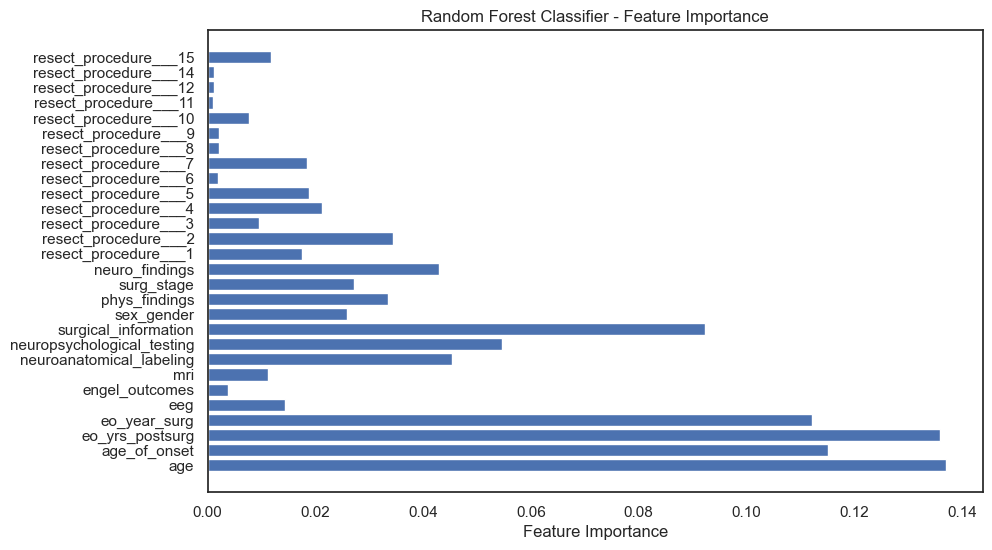

In [42]:
# Get feature importances from the trained Random Forest model
feature_importances = clf.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), column_names)
plt.xlabel("Feature Importance")
plt.title("Random Forest Classifier - Feature Importance")
plt.show()

## Support Vector Machines (SVM)

In [43]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
clf = SVC(kernel='linear', C=1, random_state=42)

# Train the classifier on the training data
clf.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.69


Positive coefficients indicate that the corresponding features are positively correlated with the target class, while negative coefficients indicate a negative correlation.

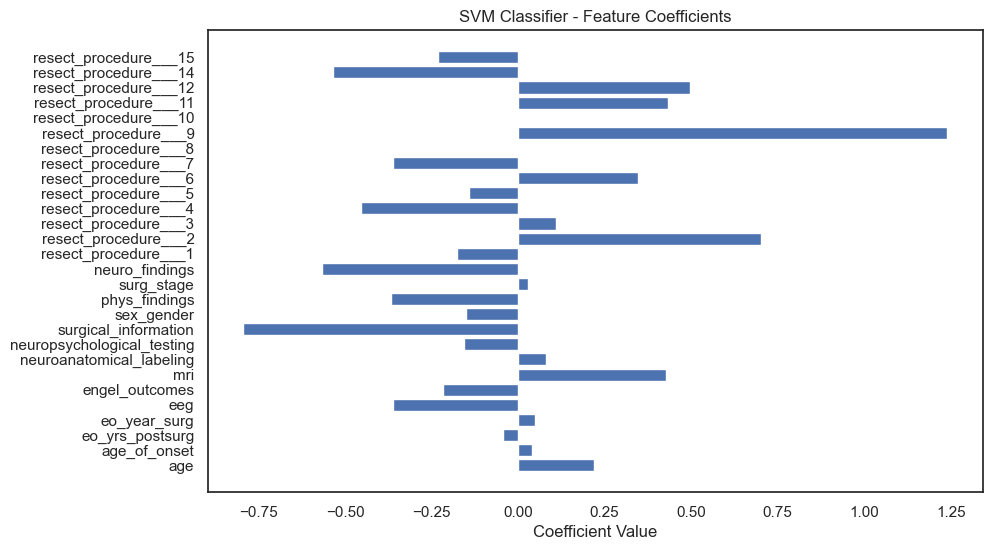

In [44]:
# Get the coefficients (weights) from the trained SVM model
coefficients = clf.coef_.flatten()

# Create a bar plot of feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(range(len(coefficients)), coefficients, align="center")
plt.yticks(range(len(coefficients)), column_names)
plt.xlabel("Coefficient Value")
plt.title("SVM Classifier - Feature Coefficients")
plt.show()

In [45]:
(X_train["engel_outcomes"]==2).sum()

4

## XGBoost

In [46]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create an XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Train the classifier on the training data
xgb.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.73


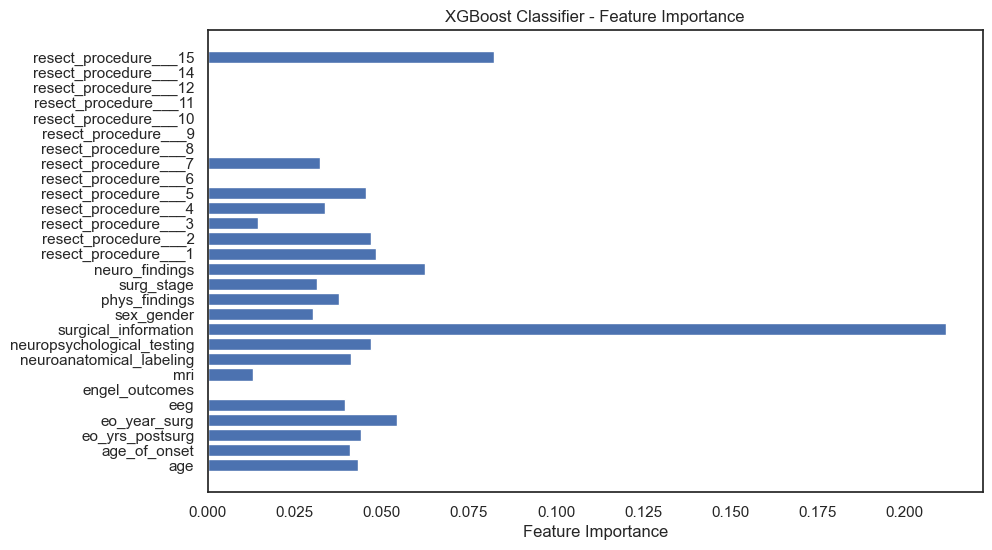

In [47]:
# Get feature importances from the trained XGBoost model
feature_importances = xgb.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), column_names)
plt.xlabel("Feature Importance")
plt.title("XGBoost Classifier - Feature Importance")
plt.show()

## Neural Network

In [48]:
import tensorflow as tf

# Create a simple neural network model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(set(y_train)), activation='softmax')  # Output layer for multiclass classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Make predictions on the test data
y_pred_prob = model.predict(X_test_scaled)
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")





Epoch 1/5


14/14 - 2s - loss: 0.6838 - accuracy: 0.5880 - val_loss: 0.6775 - val_accuracy: 0.6055 - 2s/epoch - 113ms/step
Epoch 2/5
14/14 - 0s - loss: 0.6492 - accuracy: 0.6412 - val_loss: 0.6571 - val_accuracy: 0.6147 - 67ms/epoch - 5ms/step
Epoch 3/5
14/14 - 0s - loss: 0.6206 - accuracy: 0.6782 - val_loss: 0.6401 - val_accuracy: 0.6514 - 67ms/epoch - 5ms/step
Epoch 4/5
14/14 - 0s - loss: 0.5936 - accuracy: 0.7153 - val_loss: 0.6276 - val_accuracy: 0.6147 - 65ms/epoch - 5ms/step
Epoch 5/5
14/14 - 0s - loss: 0.5741 - accuracy: 0.7407 - val_loss: 0.6194 - val_accuracy: 0.6697 - 67ms/epoch - 5ms/step
5/5 [==============================] - 0s 2ms/step
Accuracy: 0.69


## Perform PCA

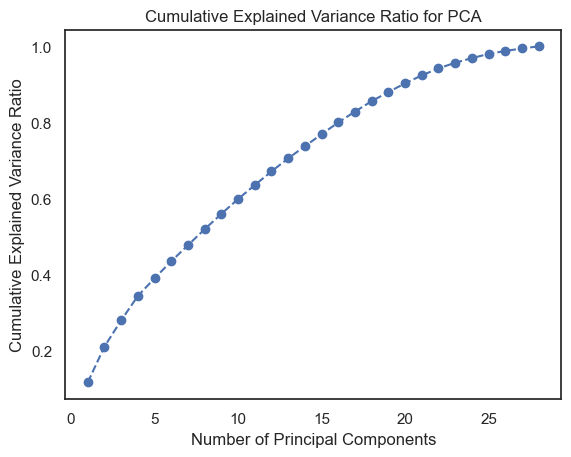

In [49]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'most_frequent'
numerical_features_imputed = pd.DataFrame(imputer.fit_transform(numerical_features), columns=numerical_features.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features_imputed)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(numerical_features_scaled)

# Plot explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for PCA')
plt.show()

In [50]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X2 = wide_df.drop(["surg_engel", "surg_engel___1", "surg_engel___2", "surg_engel___3",
                   "surg_engel___4", "engel_class1", "engel_class2", "engel_class3",
                   "engel_class4",], axis=1)
# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numerical_features, y, test_size=0.2, random_state=42)

# Impute missing values separately for training and testing sets
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Perform PCA
pca = PCA(n_components=20)  # Choose the number of components based on your analysis
pca_result_train = pca.fit_transform(X_train_scaled)
pca_result_test = pca.transform(X_test_scaled)

# Create a Random Forest classifier
clf = SVC(kernel='linear', C=1.0, random_state=42)

# Train the classifier on the training data
clf.fit(pca_result_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(pca_result_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.72


## Print system information

In [51]:
import session_info

session_info.show()

KeyError: 'pybind11_abseil'